<a href="https://colab.research.google.com/github/gui98araujo/Machine_Learning_Projects/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das bibliotecas e dados

In [ ]:
# Guilherme Marinho de Araujo
# 38445

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Upload

df_movies = pd.read_parquet('/content/movies.parquet', engine='pyarrow')
df_ratings = pd.read_parquet('/content/ratings.parquet', engine='pyarrow')

In [ ]:
df_movies

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
df_ratings

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


#Data Modeling

In [ ]:
df_ratings = df_ratings.drop(columns = ['timestamp'])

In [ ]:
df_ratings

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [ ]:
df = pd.merge(df_ratings, df_movies, how = 'left', on = 'item_id')

df.head()

,user_id,item_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,My Fair Lady (1964),Musical|Romance
3,1,3408,4,Erin Brockovich (2000),Drama
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy


# TOP 10 ratings

In [ ]:
def recommend_top_n_purchased_games(df:pd.DataFrame, n:int) -> pd.DataFrame:
  df_top_purchase = (
    # complete
    df
    .groupby('title')
    .agg({'rating': 'mean'})
    .reset_index()
    .sort_values(by='rating', ascending=False)
    .head(n)
  )
  return df_top_purchase

df_top_purchase = recommend_top_n_purchased_games(df, n=10)


In [ ]:
df_top_purchase

,title,rating
3477,Ulysses (Ulisse) (1954),5.0
2025,Lured (1947),5.0
1203,Follow the Bitch (1998),5.0
407,Bittersweet Motel (2000),5.0
3087,Song of Freedom (1936),5.0
2453,One Little Indian (1973),5.0
3044,Smashing Time (1967),5.0
2903,Schlafes Bruder (Brother of Sleep) (1995),5.0
1297,"Gate of Heavenly Peace, The (1995)",5.0
249,"Baby, The (1973)",5.0


#TOP 10 número de avaliações

In [ ]:
def recommend_top_n_purchased_games(df:pd.DataFrame, n:int) -> pd.DataFrame:
  df_top_purchase = (
    # complete
    df
    .groupby('title')
    .agg({'user_id': 'count'})
    .reset_index()
    .rename({'user_id':'avaliacoes'}, axis = 1)
    .sort_values(by='avaliacoes', ascending=False)
    .head(n)
  )
  return df_top_purchase

df_top_purchase = recommend_top_n_purchased_games(df, n=10)

In [ ]:
df_top_purchase

,title,avaliacoes
127,American Beauty (1999),3428
3153,Star Wars: Episode IV - A New Hope (1977),2991
3154,Star Wars: Episode V - The Empire Strikes Back...,2990
3155,Star Wars: Episode VI - Return of the Jedi (1983),2883
1789,Jurassic Park (1993),2672
2894,Saving Private Ryan (1998),2653
3293,Terminator 2: Judgment Day (1991),2649
2112,"Matrix, The (1999)",2590
258,Back to the Future (1985),2583
2990,"Silence of the Lambs, The (1991)",2578


# Preference Score

User consumption

In [ ]:
df_user_consumption = (
    # complete
    df
    .groupby(['user_id'])['rating']
    .sum()
    .reset_index()
    .rename({'rating': 'total_rating'}, axis=1)
)

df_user_consumption

,user_id,total_rating
0,1,222
1,2,479
2,3,199
3,4,88
4,5,623
...,...,...
6035,6036,2933
6036,6037,751
6037,6038,76
6038,6039,477


In [ ]:
df_ratings = (
  # complete
  df
  .groupby(['user_id', 'title'])['rating']
  .sum()
  .reset_index()
  .merge(df_user_consumption, on='user_id')
)

df_ratings['score'] = df_ratings['rating']/df_ratings['total_rating']
df_ratings.drop(columns=['rating','total_rating'], inplace=True)
df_ratings

,user_id,title,score
0,1,Airplane! (1980),0.018018
1,1,Aladdin (1992),0.018018
2,1,Antz (1998),0.018018
3,1,Apollo 13 (1995),0.022523
4,1,Awakenings (1990),0.022523
...,...,...,...
1000204,6040,"Wizard of Oz, The (1939)",0.004098
1000205,6040,Woman in the Dunes (Suna no onna) (1964),0.004098
1000206,6040,Women on the Verge of a Nervous Breakdown (1988),0.003279
1000207,6040,Year of Living Dangerously (1982),0.004098


# Preference Matrix

In [ ]:
df_preference_matrix = (
  # complete
  df_ratings
  .pivot(index='user_id', columns='title', values='score')
  .fillna(0)
)

df_preference_matrix

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.001023,0.0,0.0,0.0,0.0,0.000682,0.001364,0.0,0.000000,...,0.0,0.001023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000682
6037,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.005326,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6038,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


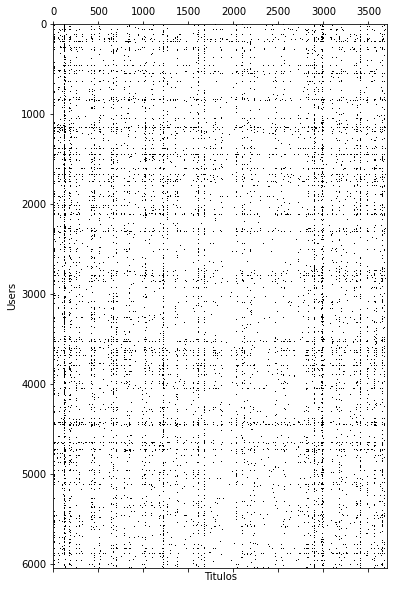

In [ ]:
def plot_matrix_sparsity(df_matrix:pd.DataFrame, figsize=(10, 10)):
  """Plots each filled value of the matrix as a dot"""
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
  ax.spy(df_matrix)
  ax.set_ylabel('Users')
  ax.set_xlabel('Titulos')

plot_matrix_sparsity(df_preference_matrix)

# Item-Based Collaborative Filtering

In [ ]:
def get_similarity_matrix(df_preference_matrix:pd.DataFrame, users:np.array=None) -> pd.DataFrame:
  """ Generates item similarity matrix from preference matrix for all or selected users """
  item_ids = df_preference_matrix.columns

  if users is None:
    users = df_preference_matrix.index

  # complete
  similarity_matrix = cosine_similarity(df_preference_matrix.loc[users].T)
  similarity_matrix = pd.DataFrame(
    similarity_matrix,
    index = item_ids,
    columns = item_ids
  )

  return similarity_matrix

similarity_matrix = get_similarity_matrix(df_preference_matrix, users=None)
similarity_matrix

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.003289,0.000261,0.003889,0.004471,0.000000,0.002998,0.171575,0.195617,0.025039,...,0.003506,0.008954,0.000000,0.000480,0.0,0.001189,0.001047,0.000000,0.002010,0.000192
'Night Mother (1986),0.003289,1.000000,0.013537,0.019190,0.038415,0.000000,0.026563,0.085660,0.012148,0.021915,...,0.002216,0.003464,0.005923,0.007305,0.0,0.005592,0.005779,0.000000,0.000000,0.003044
'Til There Was You (1997),0.000261,0.013537,1.000000,0.168311,0.090209,0.285234,0.111358,0.142497,0.029293,0.086634,...,0.000391,0.003078,0.000000,0.003692,0.0,0.000126,0.009676,0.000000,0.001419,0.002359
"'burbs, The (1989)",0.003889,0.019190,0.168311,1.000000,0.124499,0.000000,0.166533,0.137945,0.046673,0.180343,...,0.006036,0.020973,0.002243,0.004761,0.0,0.002996,0.010110,0.000000,0.000647,0.004247
...And Justice for All (1979),0.004471,0.038415,0.090209,0.124499,1.000000,0.000000,0.023645,0.116491,0.042938,0.163294,...,0.004443,0.010349,0.008611,0.005015,0.0,0.006718,0.005557,0.000421,0.000000,0.002845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A (1985)",0.001189,0.005592,0.000126,0.002996,0.006718,0.000000,0.000214,0.000857,0.000078,0.001033,...,0.005995,0.002822,0.008274,0.006889,0.0,1.000000,0.006296,0.001259,0.000000,0.010705
Zero Effect (1998),0.001047,0.005779,0.009676,0.010110,0.005557,0.000000,0.034269,0.011511,0.018689,0.013622,...,0.027860,0.021360,0.004087,0.015752,0.0,0.006296,1.000000,0.000725,0.000798,0.042703
Zero Kelvin (Kjærlighetens kjøtere) (1995),0.000000,0.000000,0.000000,0.000000,0.000421,0.000000,0.000000,0.000244,0.000000,0.000224,...,0.000479,0.000488,0.000000,0.000000,0.0,0.001259,0.000725,1.000000,0.000000,0.000316


In [ ]:
def recommend_n_most_similars(title:str, similarity_matrix:pd.DataFrame, n:int):
  assert title in similarity_matrix.index
  item_similarities = similarity_matrix.loc[title]
  # complete
  top_n_similars = (
      item_similarities
      .sort_values(ascending=False)
      .head(n)
      .reset_index()
      .rename({title: 'score'}, axis=1)
  )
  return top_n_similars

recommendations = recommend_n_most_similars(title='$1,000,000 Duck (1971)', similarity_matrix=similarity_matrix, n=11)
recommendations

,title,score
0,"$1,000,000 Duck (1971)",1.000000
1,All Dogs Go to Heaven 2 (1996),0.555090
2,"Amazing Panda Adventure, The (1995)",0.538497
3,"Adventures of Pinocchio, The (1996)",0.454704
4,Air Bud (1997),0.430529
5,Alaska (1996),0.420917
6,Pollyanna (1960),0.404718
7,Air Bud: Golden Receiver (1998),0.387243
8,All Dogs Go to Heaven (1989),0.367129
9,All the King's Men (1949),0.307655


In [ ]:
recommendations = recommend_n_most_similars(title='Star Wars: Episode IV - A New Hope (1977)', similarity_matrix=similarity_matrix, n=11)
recommendations

,title,score
0,Star Wars: Episode IV - A New Hope (1977),1.000000
1,Star Wars: Episode V - The Empire Strikes Back...,0.565524
2,Alien (1979),0.448040
3,Raiders of the Lost Ark (1981),0.441904
4,Star Wars: Episode VI - Return of the Jedi (1983),0.425896
5,"Terminator, The (1984)",0.418689
6,"Matrix, The (1999)",0.405408
7,Aliens (1986),0.387605
8,Blade Runner (1982),0.380875
9,Star Wars: Episode I - The Phantom Menace (1999),0.377113
